## ◼제주도 관광지 추천 시스템

### 0. 시스템 동작 과정

- 시스템 동작 과정
  - 키워드 선택
    - 카테고리 선택(반복)
      - 세부사항 선택 : 대표 장소, 관광지 수 입력
        - 관광지 : 이미지 선택
        - 음식점 : 이미지 선택 -> CLIP을 활용한 라벨 이용
        - 카페 : 이미지나 자연어 이용하기 어려움
      - 관광지 추천 : 유사도, 평점 등을 활용하여 관광지 추천
  - 최적 경로 탐색 : 추천된 관광지 최적 경로 탐색
    - 카카오 네비게이션 API
    - 직선 거리
  - 최적 경로 출력 : folium을 활용하여 경로 출력
    - 카카오 네비게이션 API의 경우 [오름, 산]과 같이 도로가 연결되어있지 않은 곳은 탐색 실패
    - 해당 문제를 대처하기 위해 직선 거리 경로 탐색

### 1. 사용 라이브러리

In [124]:
# 사용 라이브러리
import json
import requests
import folium
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import set_matplotlib_korean
from itertools import permutations
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

### 2. 기본 정보

**`각 파일의 path만 상황에 맞게 입력하기`**

In [125]:
# 파일 Path 및 주요 키워드
img_home = './data/220122/종합_이미지/'

# 관광명소 이미지 유사도 결과
img_euclidean_path = './data/220124/_image_euclidean_dist.npy'
# 음식점 CLIP 라벨 추가 버전
rest_clip_label = './data/220126/_음식점_CLIP라벨링.xlsx'
# 제주도 POI(장소) 데이터
jeju_poi_path = './data/220124/_종합_POI_주변관광지_추가.xlsx'

# 키워드 종류
keywords = {'1' : '테마파크',
            '2' : '감성',
            '3' : '오션뷰',
            '4' : '레포츠',
            '5' : '맛집',
            '6' : '체험',
            '7' : '가족여행',
            '8' : '분위기 좋은',
            '9' : '가볼만한 곳'}

# 카테고리 종류
categories = {'1' : '관광명소',
              '2' : '음식점',
              '3' : '카페',}

# 제주도 중심 좌표 (x, y)
jeju_pos = [126.54536611348854, 33.38394921171469]

# 시작 좌표 (x, y) : 제주국제공항
default_pos = [126.49411256317285, 33.50589515795999]

# 기본 컬럼
columns = ['idx', 'keyword', 'address_name', 'category_group_name',
       'category_name', 'id', 'place_name', 'x', 'y', 'rating', 'kind',
       'content', 'adjacent_tour', 'adjacent_rest', 'adjacent_cafe']

### 3. 시스템

#### ◼함수

##### 1) 직선 거리 계산 함수

In [126]:
# 좌표간의 직선 거리 계산 함수
# pos1 : (x좌표, y좌표)
# pos2 : (x좌표, y좌표)
def cal_dist(pos1, pos2):
    return (((pos1[1] - pos2[1])*88.8)**2 +((pos1[0] - pos2[0])*88.8)**2)**(1/2)

##### 2) 자연어 코사인 유사도 함수

In [127]:
# (content, 입력값)의 count_vector matrix 반환 함수
# keyword : 입력받은 키워드 리스트
# category : 입력받은 카테고리 리스트
# content : 장소 정보의 'content' 컬럼
#           - content : keyword + category_group_name
def get_count_mat(keyword, category, content):
    # content를 이용해 count_vector 학습
    count_vect = CountVectorizer(min_df = 0, ngram_range=(1, 2))
    content_mat = count_vect.fit_transform(content)
    input_result = keyword.copy()
    input_result.append(category)
    # count vecter를 위해 각 단어의 공백(space) 삭제
    input_result = [input_str.replace(' ', '') for input_str in input_result]
    # input_result를 이용해 count_vector 생성
    input_mat = count_vect.transform([' '.join(input_result)])

    return input_mat, content_mat


In [128]:
# input_mat 기준 sim_mat의 유사도 결과 반환
# DataFrame의 컬럼으로 추가하기 위해 reshape하여 반환
def get_cosine_sim(input_mat, sim_mat):
    input_sim = cosine_similarity(input_mat, sim_mat)
    return input_sim.reshape(-1, 1)

In [129]:
# content(keyword + category_group_name) 기준 코사인 상위 Top20 반환
# original : 코사인 유사도를 구할 원본 Dataframe
# keywords : 입력받은 keyword 리스트
# category : 코사인 유사도를 구할 카테고리명
def get_cosine_top20(original, keywords, category):
    # 코사인 유사도 획득
    input_mat, content_mat = get_count_mat(keywords, category, original['content'])
    input_sim = get_cosine_sim(input_mat, content_mat)
    # 코사인 유사도 컬럼 추가
    original['input_sim'] = input_sim

    # 유사도 결과 Top 20 반환
    return original.query(f'category_group_name == "{category}"').sort_values('input_sim', ascending=False).iloc[:20, :]

##### 3) 관광지 추천 함수

In [130]:
# 관광명소를 추천하는 함수
# 유클리드 거리와 평점을 기준으로 선정
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# past_pos : 이전 장소(좌표)
def recommand_tourism(poi_df, select_id, past_pos):
    tour_df = poi_df.query('category_group_name == "관광명소"').reset_index(drop=True)
    img_euclidean_dist = np.load(img_euclidean_path)

    idx = tour_df[tour_df['id'] == select_id].index[0]
    tour_df['img_euclidean_dist'] = img_euclidean_dist[idx]
    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    tour_df['dist'] = cal_dist(past_pos, (tour_df['x'], tour_df['y']))
    top20 = tour_df[tour_df['dist'] <= 15].sort_values('img_euclidean_dist', ascending=True).iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


In [131]:
# 음식점을 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# past_pos : 이전 장소(좌표)
def recommand_rest(poi_df, select_id, past_pos):
    rest_df = poi_df.query('category_group_name == "음식점"').reset_index(drop=True)
    food_label = pd.read_excel(rest_clip_label, index_col = False)
    rest_df.loc[:, 'food_label'] = food_label['food_label'].copy()
    food = rest_df[rest_df['id'] == select_id]['food_label'].iloc[0]
    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    rest_df['dist'] = cal_dist(past_pos, (rest_df['x'], rest_df['y']))
    top20 = rest_df.query(f'dist <= 15 and food_label == "{food}"').iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


In [132]:
# 카페를 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id(다른 함수와 동일한 형태를 유지하기 위해 사용)
# past_pos : 이전 장소(좌표)
def recommand_cafe(poi_df, select_id, past_pos):
    cafe_df = poi_df.query('category_group_name == "카페"').reset_index(drop=True)

    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    cafe_df['dist'] = cal_dist(past_pos, (cafe_df['x'], cafe_df['y']))
    top20 = cafe_df[cafe_df['dist'] <= 15].sort_values('', ascending=True).iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


In [133]:
# 매개변수 category에 따라 추천 함수 실행 후 결과 반환
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# category : 대표로 선정된 장소의 category_group_name
def recommand_site(poi_df, select_id, category, past_pos, included):
    if category == "관광명소":
        temp = recommand_tourism(poi_df, select_id, past_pos)

    elif category == "음식점":
        temp = recommand_rest(poi_df, select_id, past_pos)
    elif category == "카페":
        temp = recommand_cafe(poi_df, select_id, past_pos)
    else:
        print('오류 발생. 유효하지 않은 카테고리 입니다.')
        return None
    # 추천된 관광지 삭제
    included_idx = []
    for p_id in included:
        idx = list(temp[temp['id'] == p_id].index)
        included_idx.extend(idx)
    # 가장 순위가 높은 관광지 추천
    if included_idx:
        return temp.drop(included_idx, axis = 0).iloc[0, :]
    else:
        return temp.iloc[0, :]

##### 4) 네비게이션 경로 탐색 함수

In [134]:
# 장소 좌표를 이용해 경로 탐색
# routes : 출발지, 경로, 도착지 좌표
# 첫 인덱스 좌표 : 출발지
# 마지막 인덱스 좌표 : 도착지
# 사이의 인덱스 좌표 : 경로
def search_navi_route(routes):
    # REST 키
    rest_api_key = '63d0926cf9b14de298157081ba8a8d02'
    # 헤더
    headers = {"Authorization" : "KakaoAK {}".format(rest_api_key)}
    origin = routes[0][1]
    destination = routes[-1][1]
    waypoints = [r for p_id, r in routes[1:-1]]
    waypoints = '|'.join(waypoints)
    # 파라미터
    # origin, destination : x, y
    # waypoints : x, y| x, y|...
    url = "https://apis-navi.kakaomobility.com/v1/directions?origin={}&destination={}&waypoints={}".format(origin, destination, waypoints)

    # GET을 이용하여 획득
    res = requests.get(url, headers=headers)
    # Json을 이용하여 해제
    doc = json.loads(res.text)
    
    # 200일 경우 정상
    return res.status_code, doc

In [135]:
# 경로의 좌표, 거리, 시간 반환 함수
# routes : 출발지, 경로, 도착지 좌표
def get_navi_vertexes(routes):
    if len(routes) <= 1:
        print('장소를 추가하시기 바랍니다.(최소 장소 개수 : 2개)')
        return None, None, None
    status, doc = search_navi_route(routes)
    # 경로 탐색이 된 경우 (경로, 거리, 시간) 반환
    if status == 200 and doc['routes'][0]['result_code'] == 0:
        vertexes = []
        for section in doc['routes'][0]['sections']:
            for road in section['roads']:
                test_v = road['vertexes']
                for i in range(0, len(test_v), 2):
                    vertexes.append((test_v[i+1], test_v[i]))
        # 경로, 거리, 시간
        return vertexes, doc['routes'][0]['summary']['distance'], doc['routes'][0]['summary']['duration']
    else:
        return None, None, None

##### 5) 직선 거리 경로 탐색 함수

In [136]:
# 경로의 직선 거리 계산 함수
# routes : 전체 경로의 좌표((x, y)로 구성된 리스트 형태)
def get_straight_dist(routes):
    if len(routes) <=1 :
        print('장소를 추가하시기 바랍니다.(최소 장소 개수 : 2개)')
        return None
    straight_dist = 0
    for i in range(len(routes) - 1):
        straight_dist += cal_dist(routes[i][1:], routes[i+1][1:])

    # 거리
    return straight_dist

#### ◼메인

##### 0) 메인

In [137]:
past_poi = None
past_pos = default_pos
jeju_poi = pd.read_excel(jeju_poi_path, index_col=False)
recommand_poi = pd.DataFrame(columns=columns)

키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분
------------------------------------------------------------
	1. 테마파크
	2. 감성
	3. 오션뷰
	4. 레포츠
	5. 맛집
	6. 체험
	7. 가족여행
	8. 분위기 좋은
	9. 가볼만한 곳
------------------------------------------------------------
키워드 입력(번호 선택) : ['1', '2', '3'] - ['테마파크', '감성', '오션뷰']

카테고리를 선택해주시기 바랍니다. 단수 선택
------------------------------------------------------------
	1. 관광명소
	2. 음식점
	3. 카페
------------------------------------------------------------
카테고리 입력(번호 선택, 종료시 0) : 1 - 관광명소
------------------------------------------------------------


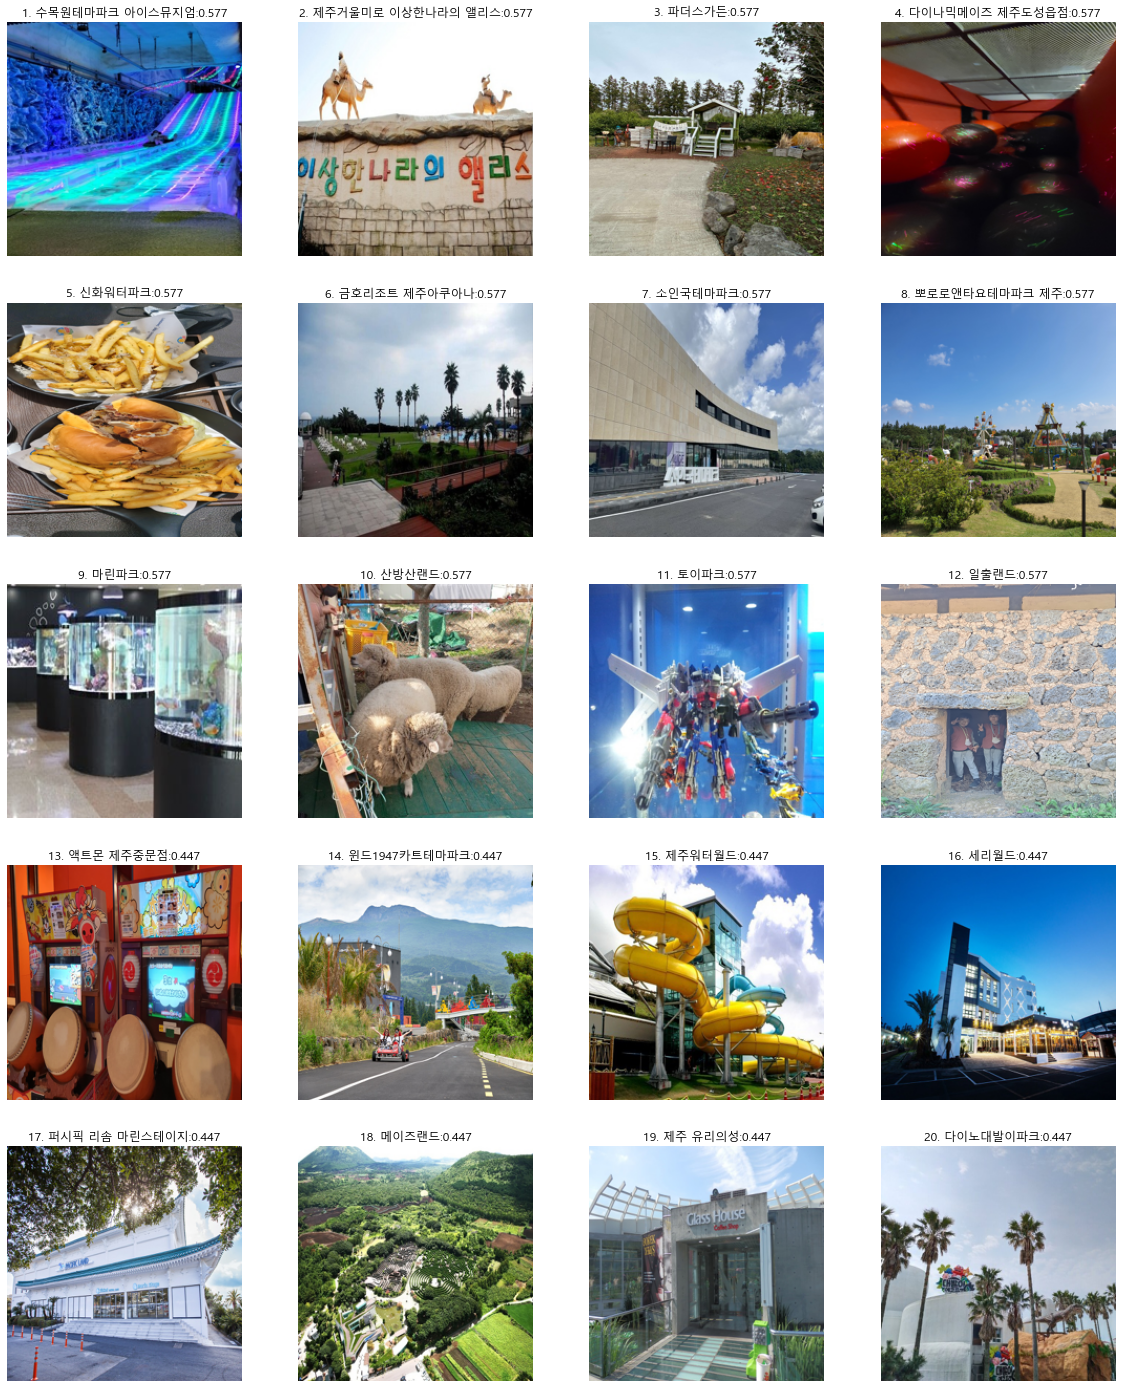

------------------------------------------------------------
대표 장소를 선택해주시기 바랍니다. 1개만 선택
------------------------------------------------------------
	1. [26388484, '수목원테마파크 아이스뮤지엄', 0.577]
	2. [12520358, '제주거울미로 이상한나라의 앨리스', 0.577]
	3. [303901411, '파더스가든', 0.577]
	4. [1527411751, '다이나믹메이즈 제주도성읍점', 0.577]
	5. [1870273669, '신화워터파크', 0.577]
	6. [12665029, '금호리조트 제주아쿠아나', 0.577]
	7. [11330871, '소인국테마파크', 0.577]
	8. [942616668, '뽀로로앤타요테마파크 제주', 0.577]
	9. [9720913, '마린파크', 0.577]
	10. [11059651, '산방산랜드', 0.577]
	11. [17630155, '토이파크', 0.577]
	12. [10399499, '일출랜드', 0.577]
	13. [780499262, '액트몬 제주중문점', 0.447]
	14. [820826091, '윈드1947카트테마파크', 0.447]
	15. [17150892, '제주워터월드', 0.447]
	16. [10472331, '세리월드', 0.447]
	17. [10880885, '퍼시픽 리솜 마린스테이지', 0.447]
	18. [13095815, '메이즈랜드', 0.447]
	19. [8064310, '제주 유리의성', 0.447]
	20. [107991673, '다이노대발이파크', 0.447]
------------------------------------------------------------
입력(번호 선택) : 1 - 수목원테마파크 아이스뮤지엄

카테고리를 선택해주시기 바랍니다. 단수 선택
--------------------------

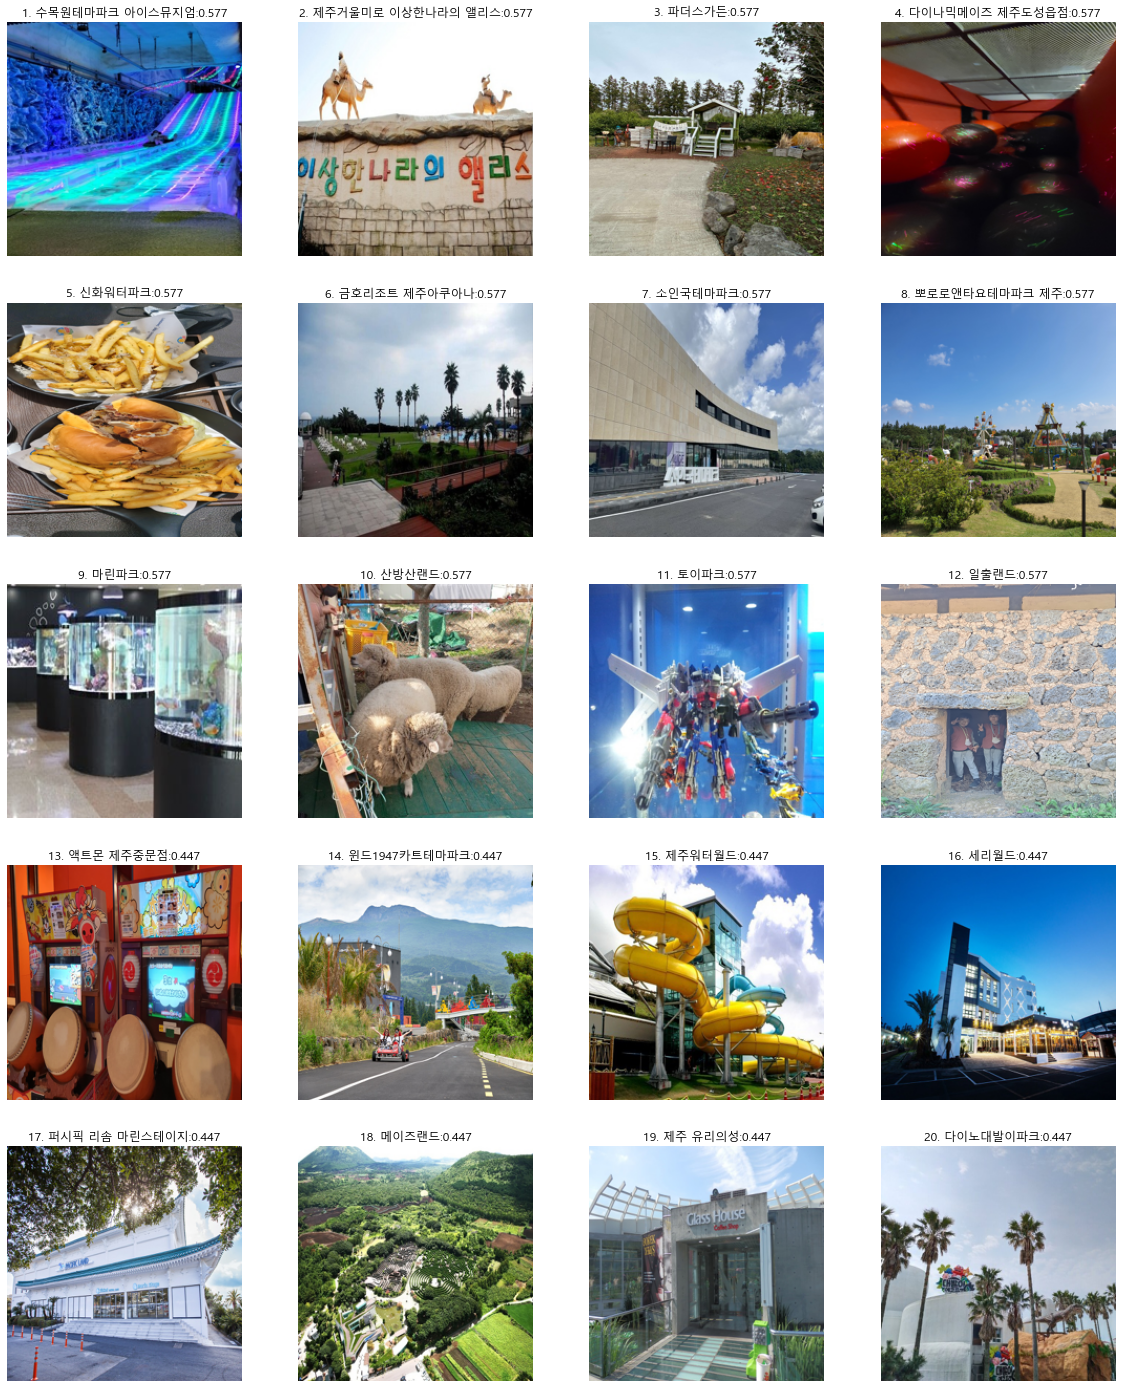

------------------------------------------------------------
대표 장소를 선택해주시기 바랍니다. 1개만 선택
------------------------------------------------------------
	1. [26388484, '수목원테마파크 아이스뮤지엄', 0.577]
	2. [12520358, '제주거울미로 이상한나라의 앨리스', 0.577]
	3. [303901411, '파더스가든', 0.577]
	4. [1527411751, '다이나믹메이즈 제주도성읍점', 0.577]
	5. [1870273669, '신화워터파크', 0.577]
	6. [12665029, '금호리조트 제주아쿠아나', 0.577]
	7. [11330871, '소인국테마파크', 0.577]
	8. [942616668, '뽀로로앤타요테마파크 제주', 0.577]
	9. [9720913, '마린파크', 0.577]
	10. [11059651, '산방산랜드', 0.577]
	11. [17630155, '토이파크', 0.577]
	12. [10399499, '일출랜드', 0.577]
	13. [780499262, '액트몬 제주중문점', 0.447]
	14. [820826091, '윈드1947카트테마파크', 0.447]
	15. [17150892, '제주워터월드', 0.447]
	16. [10472331, '세리월드', 0.447]
	17. [10880885, '퍼시픽 리솜 마린스테이지', 0.447]
	18. [13095815, '메이즈랜드', 0.447]
	19. [8064310, '제주 유리의성', 0.447]
	20. [107991673, '다이노대발이파크', 0.447]
------------------------------------------------------------
입력(번호 선택) : 3 - 파더스가든

카테고리를 선택해주시기 바랍니다. 단수 선택
-----------------------------------

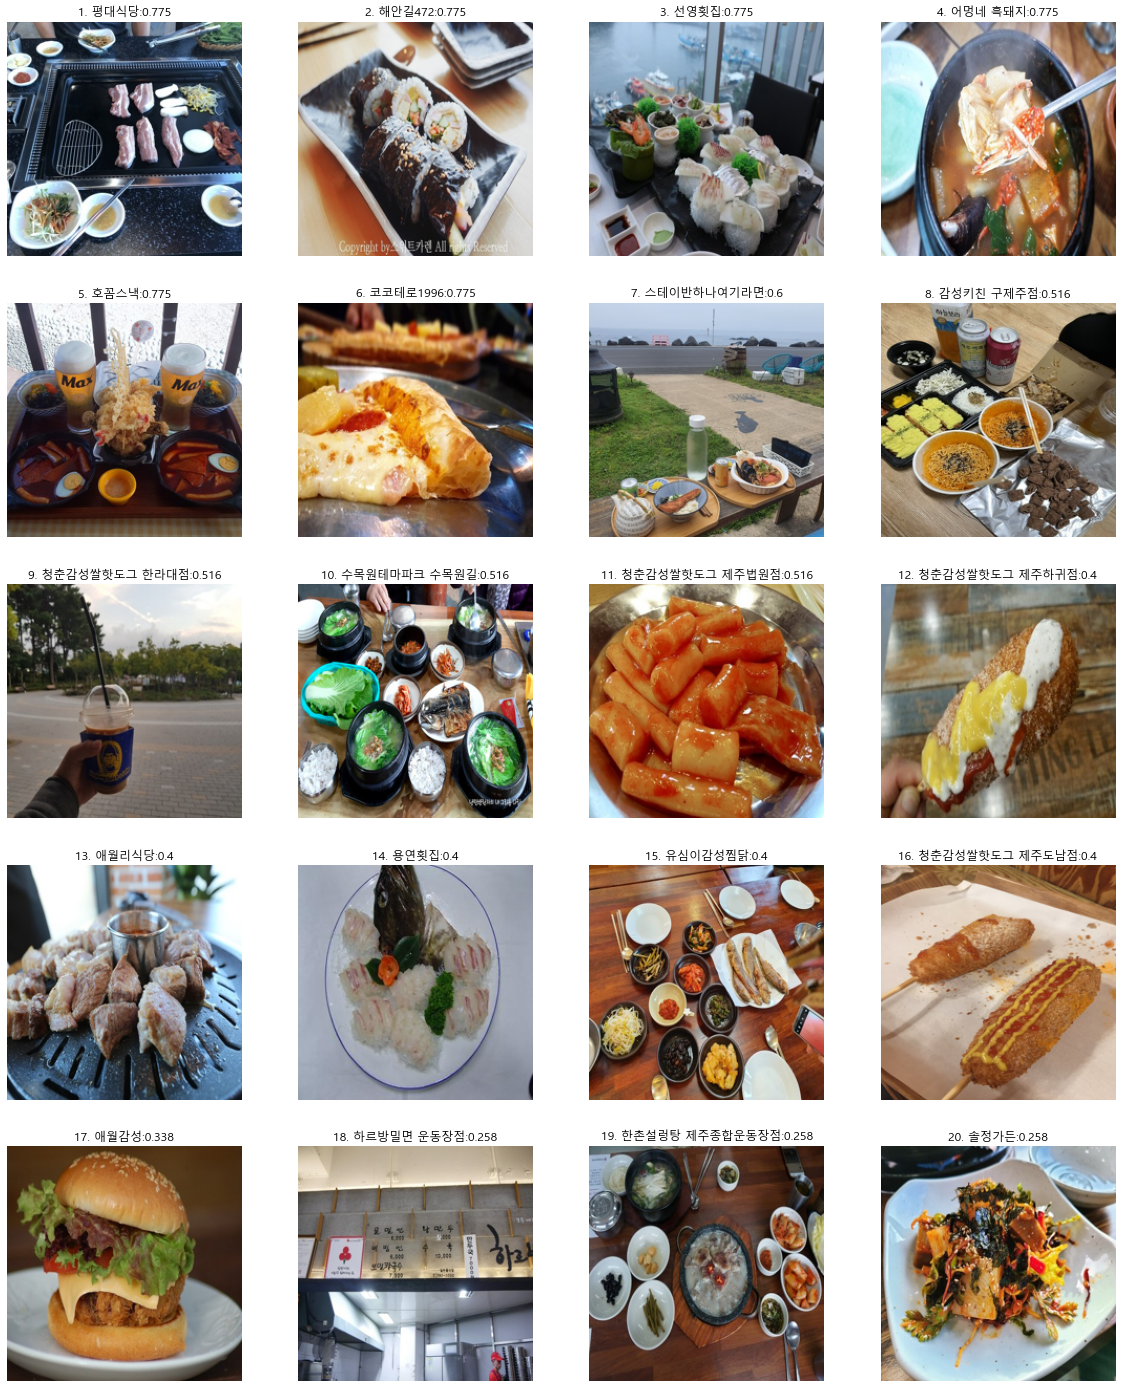

------------------------------------------------------------
대표 장소를 선택해주시기 바랍니다. 1개만 선택
------------------------------------------------------------
	1. [2917003, '평대식당', 0.775]
	2. [2066964307, '해안길472', 0.775]
	3. [15241915, '선영횟집', 0.775]
	4. [1556251353, '어멍네 흑돼지', 0.775]
	5. [859714916, '호꼼스낵', 0.775]
	6. [1752508979, '코코테로1996', 0.775]
	7. [1509821727, '스테이반하나여기라면', 0.6]
	8. [155598859, '감성키친 구제주점', 0.516]
	9. [563366856, '청춘감성쌀핫도그 한라대점', 0.516]
	10. [836599965, '수목원테마파크 수목원길', 0.516]
	11. [212161428, '청춘감성쌀핫도그 제주법원점', 0.516]
	12. [2059941517, '청춘감성쌀핫도그 제주하귀점', 0.4]
	13. [428056777, '애월리식당', 0.4]
	14. [11188530, '용연횟집', 0.4]
	15. [872614742, '유심이감성찜닭', 0.4]
	16. [1060962010, '청춘감성쌀핫도그 제주도남점', 0.4]
	17. [758677714, '애월감성', 0.338]
	18. [24658737, '하르방밀면 운동장점', 0.258]
	19. [1986004591, '한촌설렁탕 제주종합운동장점', 0.258]
	20. [15095661, '솔정가든', 0.258]
------------------------------------------------------------
입력(번호 선택) : 12 - 청춘감성쌀핫도그 제주하귀점

카테고리를 선택해주시기 바랍니다. 단수 선택
-------------------------

In [138]:
# 키워드 입력
print('키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분')
print('-'*60)
for key, value in keywords.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('키워드 입력(번호 선택) : ', end ='')
keyword_nums = input().split(' ')
keyword_result = [keywords[key] for key in keyword_nums]
print(keyword_nums, '-', keyword_result)
print()

while True:
    # 키워드 입력
    print('카테고리를 선택해주시기 바랍니다. 단수 선택')
    print('-'*60)
    for key, value in categories.items():
        print('\t{}. {}'.format(key, value))
    print('-'*60)
    print('카테고리 입력(번호 선택, 종료시 0) : ', end ='')
    category_num = input()
    if category_num == '0':
        print('종료') # 종료 문구
        break
    else:
        category_result = categories[category_num]
        print(category_num, '-', category_result)
    
    # 카페가 아닌 경우 코사인 유사도 확인
    if category_result != '카페':
        print('-'*60)
        cosine_poi = get_cosine_top20(jeju_poi.copy(), keyword_result, category_result)
        if cosine_poi is not None:
            cosine_poi = cosine_poi.reset_index(drop=True)
        # 대표 장소 선택
        img_info = {}
        plt.figure(figsize=(20, 25))
        cnt = 1
        for idx, row in cosine_poi.iterrows():
            plt.subplot(5, 4, cnt)
            img_path = img_home + row['category_group_name'] + '/'+str(row['id'])+'_'+row['place_name']+'.png'
            img = plt.imread(img_path)
            plt.imshow(img)
            title = str(cnt) + '. ' + row['place_name'] + ':' + str(round(row['input_sim'], 3))
            plt.gca().set_title(title)
            plt.axis(False)
            img_info[str(cnt)] = [row['id'], row['place_name'], round(row['input_sim'], 3)]
            cnt += 1
        plt.show()
        print('-'*60)
        print('대표 장소를 선택해주시기 바랍니다. 1개만 선택')
        print('-'*60)
        for key, value in img_info.items():
            print('\t{}. {}'.format(key, value))
        print('-'*60)
        print('입력(번호 선택) : ', end='')
        cosine_num = int(input())
        cosine_result = cosine_poi.iloc[cosine_num-1, :]
        print(cosine_num, '-', cosine_result['place_name'])
        print()
        
    # 관광지 추천
    included = list(recommand_poi['id'])
    if category_result == '카페':
        recommand_poi = recommand_poi.append(recommand_site(jeju_poi, None, category_result, past_pos, included))
    else:
        recommand_poi = recommand_poi.append(recommand_site(jeju_poi, cosine_result['id'], category_result, past_pos, included))
    past_pos = [recommand_poi.iloc[-1]['x'], recommand_poi.iloc[-1]['y']]
        

##### 1) 최적 경로 탐색

In [142]:
# 네비게이션 최적 경로 탐색
navi_points = []
default_point = (1, str(default_pos[0])+', '+str(default_pos[1]))
min_navi_points, min_navi_vertexes, min_navi_dist, min_navi_duration = None, None, -1, -1
for idx, row in recommand_poi.iterrows():
    navi_points.append((row['id'], str(row['x'])+', '+str(row['y'])))

for points in permutations(navi_points, len(navi_points)):
    navi_vertexes, navi_dist, navi_duration = get_navi_vertexes([default_point] + list(points))
    if navi_vertexes is not None:
        if min_navi_points is None:
            min_navi_points = points
            min_navi_vertexes = navi_vertexes
            min_navi_dist = navi_dist
            min_navi_duration = navi_duration
        else:
            if min_navi_duration > navi_duration:
                min_navi_points = points
                min_navi_vertexes = navi_vertexes
                min_navi_dist = navi_dist
                min_navi_duration = navi_duration
    else:
        print('경로 탐색 실패')
        break

경로 탐색 실패


In [146]:
# 직선 거리 최적 경로 탐색
straight_points = []
default_point = (1, default_pos[0], default_pos[1])
min_straight_points, min_straight_dist = None, -1
for idx, row in recommand_poi.iterrows():
    straight_points.append((row['id'], float(row['x']), float(row['y'])))

for points in permutations(straight_points, len(straight_points)):
    straight_dist = get_straight_dist([default_point] + list(points))
    if min_straight_points is None:
        min_straight_points = points
        min_straight_dist = straight_dist
    else:
        if min_straight_dist > straight_dist:
            min_straight_points = points
            min_straight_dist = straight_dist
straight_vertexes = [(y, x) for p_id, x, y in min_straight_points]

##### 2) 최적 경로 표현 : 네비게이션 경로

In [144]:
navi_map = None
if navi_vertexes is not None:
    navi_map = folium.Map(location=[jeju_pos[1], jeju_pos[0]], zoom_start=9)
    folium.Marker(location=[default_pos[1], default_pos[0]], popup="출발 지점").add_to(navi_map)
    for p_id, pos in navi_points:
        x, y = map(float, pos.replace(' ', '').split(','))
        folium.Marker(location=[y, x], popup=p_id).add_to(navi_map)
    folium.PolyLine([(default_pos[1], default_pos[0])] + navi_vertexes, color='red').add_to(navi_map)
else:
    print("경로 탐색 실패")
navi_map

경로 탐색 실패


##### 3) 직선 경로 표현

In [153]:
straight_map = folium.Map(location=[jeju_pos[1], jeju_pos[0]], zoom_start=11)
folium.Marker(location=[default_pos[1], default_pos[0]], popup="출발 지점").add_to(straight_map)
for p_id, x, y in min_straight_points:
    p_name = jeju_poi.loc[jeju_poi['id'] == p_id, 'place_name'].values[0]
    folium.Marker(location=[y, x], popup=str(p_name)).add_to(straight_map)
folium.PolyLine([(default_pos[1], default_pos[0])] + straight_vertexes, color='red').add_to(straight_map)
straight_map